https://www.bualabs.com/archives/3000/sentiment-classification-imdb-movie-reviews-with-naive-bayes-logistic-regression-nlp-ep-5/

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

https://www.analyticsvidhya.com/blog/2018/11/tutorial-text-classification-ulmfit-fastai-library/

In [2]:
# import libraries
import fastai
from fastai import *
from fastai.text import * 
import pandas as pd
import numpy as np
from functools import partial
import io
import os

In [3]:
!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
!pip install fastai

Looking in links: https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
ERROR: Could not find a version that satisfies the requirement torch_nightly
ERROR: No matching distribution found for torch_nightly


In [4]:
path = untar_data(URLs.IMDB_SAMPLE)
path

WindowsPath('C:/Users/user/.fastai/data/imdb_sample')

In [5]:
path.ls()  #ดูว่ามีไฟล์อะไรบ้าง

[WindowsPath('C:/Users/user/.fastai/data/imdb_sample/texts.csv')]

In [6]:
df = pd.read_csv(path/'texts.csv')  #โหลดไฟล์ csv ขึ้นมา ใส่ Pandas Dataframe
df.shape

(1000, 3)

#มีข้อมูลตัวอย่าง 1000 Record, 3 Column ดูตัวอย่างข้อมูล 5 Record แรก
df.head()

In [9]:
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


Preprocessing

In [7]:
movie_reviews = (TextList.from_csv(path, 'texts.csv', cols='text').split_from_df(col=2).label_from_df(cols=0))
 #เราจะใช้ Fastai TextList ในการ Preprocess ข้อมูล เช่น Tokenization, Numberization, etc.
 #จะได้ Trainint Set, Validation Set ออกมา เรามาดูข้อมูลตัวอย่าง Record แรกใน Validation Set

https://medium.com/ai-in-plain-english/fast-natural-language-processing-101-cf1afefdc449

In [11]:
movie_reviews.valid.y[0], movie_reviews.valid.x[0]


(Category 1, Text [ 2  5 21 71 ... 15  5  0 52])

In [12]:
len(movie_reviews.train.x), len(movie_reviews.valid.x)

(800, 200)

In [13]:
len(movie_reviews.vocab.itos), len(movie_reviews.vocab.stoi)

(6008, 19159)

In [14]:
movie_reviews.vocab.stoi['love']

142

In [15]:
movie_reviews.vocab.itos[142]

'love'

In [16]:
movie_reviews.vocab.itos[140:149]

['life', 'characters', 'love', 'your', 'here', 'know', 'scenes', 'best', 'end']

In [17]:
movie_reviews.vocab.itos[-20:]

['uncritical',
 'whack',
 'heavies',
 'poe',
 'monstervision',
 'penn',
 'shrine',
 'lupino',
 'pegg',
 'grasshoppers',
 'flik',
 'ladder',
 'wtc',
 'portuguese',
 'della',
 'contractor',
 'coaxes',
 'mabuse',
 'greyson',
 'sollett']

In [18]:
from itertools import *
list(islice(movie_reviews.vocab.stoi.items(), 20))

[('xxunk', 0),
 ('xxpad', 1),
 ('xxbos', 2),
 ('xxeos', 3),
 ('xxfld', 4),
 ('xxmaj', 5),
 ('xxup', 6),
 ('xxrep', 7),
 ('xxwrep', 8),
 ('the', 9),
 ('.', 10),
 (',', 11),
 ('and', 12),
 ('a', 13),
 ('of', 14),
 ('to', 15),
 ('is', 16),
 ('it', 17),
 ('in', 18),
 ('i', 19)]

คำที่อยู่นอก vocab Dictionary จะถูก Map เป็น Unknown (xxunk)

In [19]:
i = movie_reviews.vocab.stoi['eiei']
movie_reviews.vocab.itos[i], i

('xxunk', 0)

In [20]:
t = movie_reviews.train[0][0]

In [21]:
t

Text [   2    5 4619   25 ...   10    5    0   52]

In [22]:
df

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False
...,...,...,...
995,negative,There are many different versions of this one ...,True
996,positive,Once upon a time Hollywood produced live-actio...,True
997,negative,Wenders was great with Million $ Hotel.I don't...,True
998,negative,Although a film with Bruce Willis is always wo...,True


In [23]:
t.data[:30]

array([   2,    5, 4619,   25,    0,   25,  867,   52,    5, 3776,    5, 1800,   95,   37,   85,  192,   64,  935,
          0, 2738,  517,   18,   21,   11,   84, 2417,  193,   88, 3777,   64], dtype=int64)

Creating Term-Document Matrix

1)Counter

In [24]:
c = Counter([1, 2, 3, 4, 5, 
             1, 2, 3, 4, 
             1, 2, 3, 
             1, 2, 
             1])

In [25]:
c

Counter({1: 5, 2: 4, 3: 3, 4: 2, 5: 1})

นับครั้งdata ที่ปรากฎบน dict

In [26]:
c.keys(), c.values()

(dict_keys([1, 2, 3, 4, 5]), dict_values([5, 4, 3, 2, 1]))

2) Term-Document Matrix as Sparse Matrix

In [27]:
c = Counter(movie_reviews.valid.x[0].data)
len(c), c

(95,
 Counter({2: 1,
          5: 32,
          21: 3,
          71: 1,
          190: 1,
          748: 1,
          288: 1,
          285: 1,
          63: 2,
          221: 1,
          666: 2,
          59: 1,
          13: 4,
          2705: 1,
          14: 6,
          2875: 1,
          11: 10,
          18: 2,
          358: 1,
          0: 32,
          77: 1,
          15: 6,
          478: 1,
          1833: 1,
          50: 3,
          9: 10,
          319: 1,
          6: 1,
          2743: 1,
          12: 1,
          115: 1,
          4126: 1,
          197: 2,
          1331: 1,
          25: 2,
          324: 1,
          10: 7,
          3963: 1,
          16: 4,
          74: 1,
          24: 3,
          2817: 1,
          5821: 1,
          2595: 1,
          710: 1,
          3429: 1,
          84: 1,
          149: 1,
          20: 1,
          26: 1,
          605: 1,
          378: 1,
          1058: 1,
          251: 1,
          258: 1,
          1346: 1,


In [28]:
idx = [0, 2, 5, 6, 9]
[movie_reviews.vocab.itos[i] for i in idx]

['xxunk', 'xxbos', 'xxmaj', 'xxup', 'the']

In [29]:
movie_reviews.valid.y[1], movie_reviews.valid.x[1]

(Category 1, Text [  2  19 248  21 ...   9   0  10   0])

ประกาศฟังก์ชัน สร้าง Term-Document Matrix โดย output เป็น Sparse Matrix แบบ Compressed sparse row (CSR, CRS หรือ Yale format)

In [30]:
def get_term_doc_matrix(label_list, vocab_len):
    j_indices = []
    indptr = []
    values = []
    indptr.append(0)

    for i, doc in enumerate(label_list):
        feature_counter = Counter(doc.data)
        j_indices.extend(feature_counter.keys())
        values.extend(feature_counter.values())
        indptr.append(len(j_indices))

    # return (values, j_indices, indptr)

    return scipy.sparse.csr_matrix((values, j_indices, indptr), 
                                   shape=(len(indptr)-1, vocab_len), 
                                   dtype=int)

จับเวลาการสร้าง Term-Document Matrix ด้วยข้อมูล Validation Set

In [31]:
%%time
val_term_doc = get_term_doc_matrix(movie_reviews.valid.x, len(movie_reviews.vocab.itos))

Wall time: 54.8 ms


จับเวลาการสร้าง Term-Document Matrix ด้วยข้อมูล Training Set

In [32]:
%%time
trn_term_doc = get_term_doc_matrix(movie_reviews.train.x, len(movie_reviews.vocab.itos))

Wall time: 230 ms


In [33]:

trn_term_doc.shape

(800, 6008)

In [34]:
val_term_doc.shape

(200, 6008)

3)Sparse Matrix vs Dense Matrix

In [35]:
trn_term_doc[:, -10:]

<800x10 sparse matrix of type '<class 'numpy.intc'>'
	with 10 stored elements in Compressed Sparse Row format>

In [36]:
trn_term_doc.todense()[:8, :8]

matrix([[ 8,  0,  1,  0,  0, 15,  0,  0],
        [22,  0,  1,  0,  0, 33,  2,  0],
        [ 4,  0,  1,  0,  0, 16,  2,  0],
        [13,  0,  1,  0,  0, 11,  0,  0],
        [12,  0,  1,  0,  0, 21,  0,  0],
        [ 4,  0,  1,  0,  0, 12,  1,  0],
        [ 4,  0,  1,  0,  0, 15,  0,  0],
        [42,  0,  1,  0,  0, 43, 14,  0]])

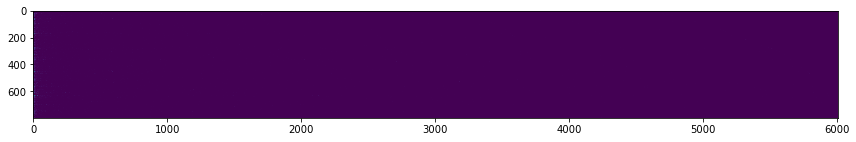

In [37]:
fig, ax = plt.subplots(figsize=(12, 2))
ax.imshow(trn_term_doc.todense(), interpolation='nearest')
plt.tight_layout()

ซูมดู

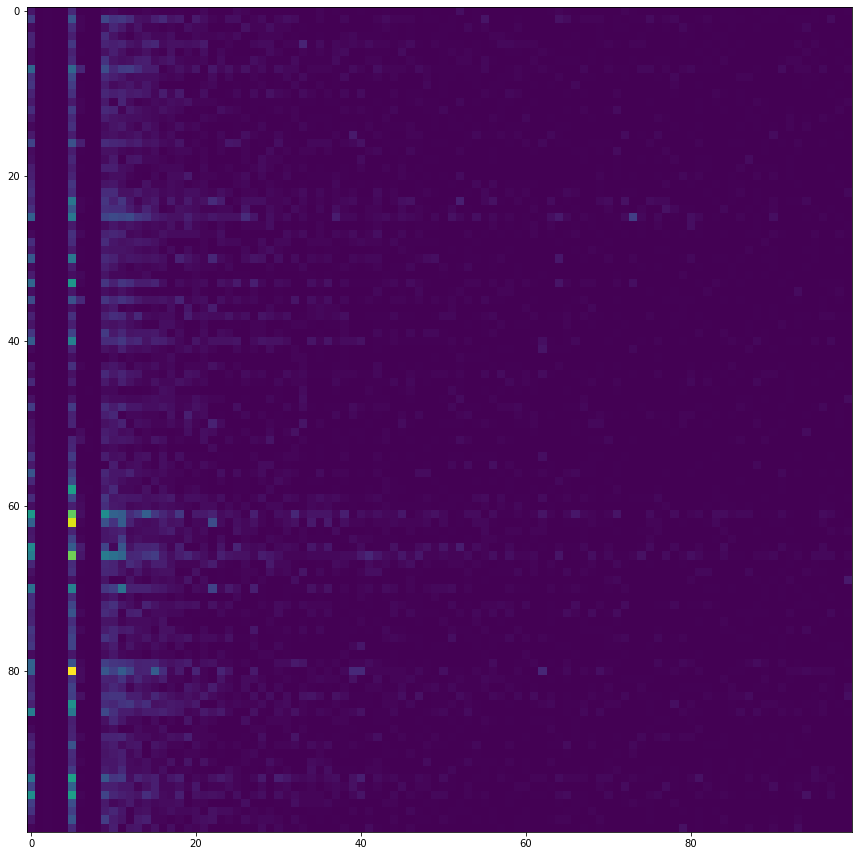

In [38]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(trn_term_doc.todense()[:100, :100], interpolation='nearest')
plt.tight_layout()

4) Data Exploration

In [39]:

v = movie_reviews.vocab

In [40]:
v.itos[0]

'xxunk'

In [41]:
v.itos[-1:]

['sollett']

In [42]:
v.itos[3]

'xxeos'

In [43]:
v.itos[5]

'xxmaj'

In [44]:
review = movie_reviews.valid.x[1]; review

Text [  2  19 248  21 ...   9   0  10   0]

In [45]:
i = v.stoi['late']; i

451